In [1]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

bank_data = pd.read_csv('bank-additional-full.csv')

C:\Users\Milos\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Handling categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome', 'y']
bank_data_tran = pd.get_dummies(bank_data, columns = categorical_features, drop_first=True)

bank_data_tran.drop(['duration'], axis = 1, inplace = True)
#bank_data_tran.drop(['job_blue-collar', 'job_self-employed', 'job_services', 'job_unemployed', 'day_of_week_mon'], axis = 1, inplace = True)

#because of the high correlation coefficient between euribor3m rate and nr. of employed, the latter is going to be dropped
bank_data_tran.drop(['nr.employed'], axis = 1, inplace = True)

#apllying the same logic, emp.var.rate is going to be dropped
bank_data_tran.drop(['emp.var.rate'], axis = 1, inplace = True)

In [3]:
#Data preprocessing and splitting and scaling
x = bank_data_tran.iloc[:,bank_data_tran.columns != 'y_yes'].values
y = bank_data_tran.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

In [4]:
sm = SMOTE(random_state=12, ratio = 1.0, k_neighbors = 5)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [5]:
#Function for printing results
def print_results(x_input, true_output, predicted_output, classifier):
    precision, recall, thresholds = precision_recall_curve(true_output, classifier.predict_proba(x_input)[:,1])
    area = auc(recall, precision)
    print("\nArea under precission-recall is:", area)
    
    print("Validation set predictions: \n\n" + classification_report(true_output,predicted_output))
    print("\n Confusion matrix:\n " , confusion_matrix(true_output, predicted_output))
    print("\n")
    print("True negatives:", confusion_matrix(true_output, predicted_output)[0][0])
    print("False positives:", confusion_matrix(true_output, predicted_output)[0][1])
    print("False negatives:", confusion_matrix(true_output, predicted_output)[1][0])
    print("True positives: ", confusion_matrix(true_output, predicted_output)[1][1])

# Decision trees
- <h4> Model training </h4> 

In [6]:
#Decision tree algorithm

td_classifier = DecisionTreeClassifier(criterion='entropy', random_state = 0, splitter = 'best')
td_classifier.fit(x_train_res, y_train_res)

predictions_DT_val = td_classifier.predict(x_val)

print_results(x_val, y_val, predictions_DT_val, td_classifier)


Area under precission-recall is: 0.3608060856142112
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.91      0.90      0.90      5841
          1       0.30      0.34      0.32       749

avg / total       0.84      0.83      0.84      6590


 Confusion matrix:
  [[5233  608]
 [ 491  258]]


True negatives: 5233
False positives: 608
False negatives: 491
True positives:  258


- <h4> Model testing 

In [8]:
predictions_DT_test = td_classifier.predict(x_test)
print_results(x_test, y_test, predictions_DT_test, td_classifier)


Area under precission-recall is: 0.341254205663708
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.91      0.91      0.91      7319
          1       0.29      0.31      0.30       919

avg / total       0.84      0.84      0.84      8238


 Confusion matrix:
  [[6624  695]
 [ 631  288]]


True negatives: 6624
False positives: 695
False negatives: 631
True positives:  288


Area under Reciver Operating Characteristic Curve is:  0.6092128927630486


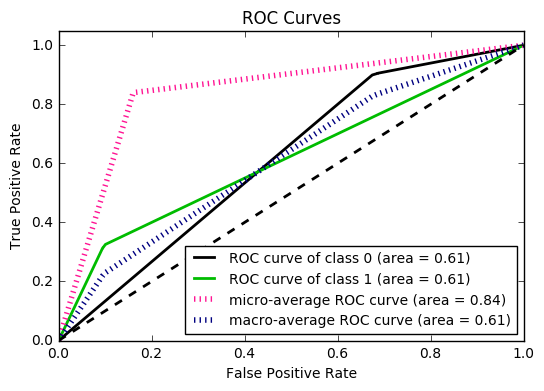

In [9]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_DT_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = td_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Ada Boost - Decision Trees
- <h4> Model training

In [10]:
#Boosting - AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                         algorithm = "SAMME",
                         n_estimators=200)
                         
ada.fit(x_train_res, y_train_res)
predictions_ada = ada.predict(x_val)

print_results(x_val, y_val, predictions_ada, ada)


Area under precission-recall is: 0.36797175358824724
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      5841
          1       0.49      0.31      0.38       749

avg / total       0.87      0.88      0.87      6590


 Confusion matrix:
  [[5600  241]
 [ 519  230]]


True negatives: 5600
False positives: 241
False negatives: 519
True positives:  230


- <h4> Model testing

In [11]:
predictions_ada_test = ada.predict(x_test)
print_results(x_test, y_test, predictions_ada_test, ada)


Area under precission-recall is: 0.34522934127898186
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.91      0.96      0.94      7319
          1       0.46      0.28      0.35       919

avg / total       0.86      0.88      0.87      8238


 Confusion matrix:
  [[7015  304]
 [ 664  255]]


True negatives: 7015
False positives: 304
False negatives: 664
True positives:  255


Area under Reciver Operating Characteristic Curve is:  0.6179698939707212


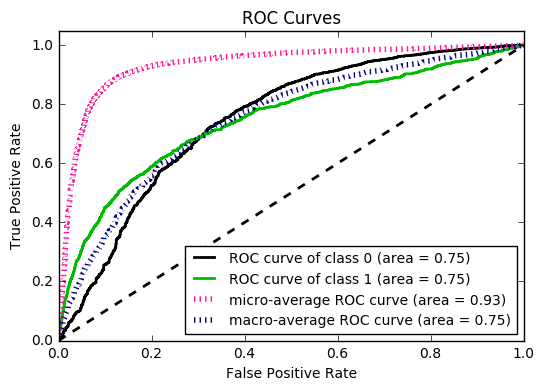

In [12]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_ada_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = ada.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Gradient Boosting
- <h4> Model training

In [13]:
#Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gradientBoost = GradientBoostingClassifier(n_estimators=100, random_state=1)
gradientBoost.fit(x_train_res, y_train_res)

gradient_predictions = gradientBoost.predict(x_val)

#Results
print_results(x_val, y_val, gradient_predictions, gradientBoost)


Area under precission-recall is: 0.4681621033878043
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.96      0.94      5841
          1       0.54      0.40      0.46       749

avg / total       0.88      0.89      0.89      6590


 Confusion matrix:
  [[5582  259]
 [ 450  299]]


True negatives: 5582
False positives: 259
False negatives: 450
True positives:  299


- <h4> Model testing

In [14]:
predictions_GradB_test = gradientBoost.predict(x_test)
print_results(x_test, y_test, predictions_GradB_test, classifier=gradientBoost)


Area under precission-recall is: 0.433546039811142
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      7319
          1       0.51      0.36      0.42       919

avg / total       0.88      0.89      0.88      8238


 Confusion matrix:
  [[7005  314]
 [ 587  332]]


True negatives: 7005
False positives: 314
False negatives: 587
True positives:  332


Area under Reciver Operating Characteristic Curve is:  0.6591801028848403


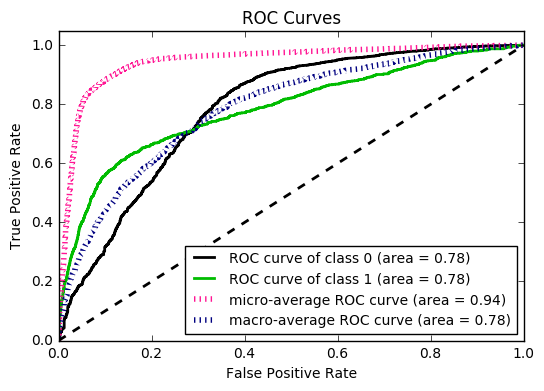

In [15]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_GradB_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = gradientBoost.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Bagging - Decision Trees
- <h4> Model training

In [16]:
#Bagging with decission trees
from sklearn.ensemble import BaggingClassifier
bagg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=100, random_state=7)
bagg.fit(x_train_res, y_train_res)

predictions_bag = bagg.predict(x_val)

#Results
print_results(x_val, y_val, predictions_bag, bagg)


Area under precission-recall is: 0.42986021945119174
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.95      0.94      5841
          1       0.50      0.38      0.43       749

avg / total       0.87      0.89      0.88      6590


 Confusion matrix:
  [[5556  285]
 [ 468  281]]


True negatives: 5556
False positives: 285
False negatives: 468
True positives:  281


- <h4> Model testing

In [17]:
predictions_bagg_test = bagg.predict(x_test)
print_results(x_test, y_test, predictions_bagg_test, bagg)


Area under precission-recall is: 0.3873874824451548
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      7319
          1       0.49      0.34      0.40       919

avg / total       0.87      0.89      0.88      8238


 Confusion matrix:
  [[6996  323]
 [ 610  309]]


True negatives: 6996
False positives: 323
False negatives: 610
True positives:  309


Area under Reciver Operating Characteristic Curve is:  0.6460516630511818


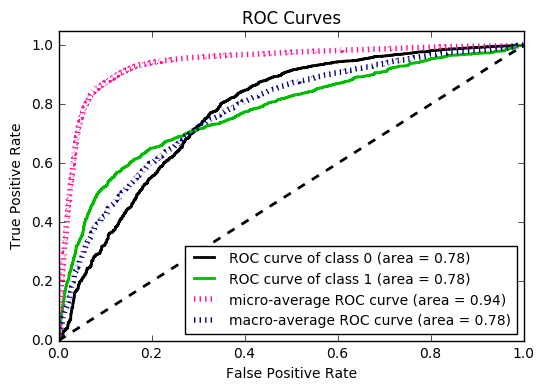

In [18]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_bagg_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = bagg.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()


# Random Forest Classifier
- <h4> Model training

In [19]:
#Random Forest Classification Algorithm

# Fitting Random Forest Classification to the Training set
rf_classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
rf_classifier.fit(x_train_res, y_train_res)

predictions_RF_val = rf_classifier.predict(x_val)

#Results
print_results(x_val, y_val, predictions_RF_val, rf_classifier)


Area under precission-recall is: 0.43393971992403335
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      5841
          1       0.53      0.32      0.40       749

avg / total       0.87      0.89      0.88      6590


 Confusion matrix:
  [[5630  211]
 [ 507  242]]


True negatives: 5630
False positives: 211
False negatives: 507
True positives:  242


- <h4> Model testing

In [20]:
predictions_RF_test = rf_classifier.predict(x_test)
print_results(x_test, y_test, predictions_RF_test, rf_classifier)


Area under precission-recall is: 0.41515329225403996
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.97      0.94      7319
          1       0.53      0.30      0.39       919

avg / total       0.87      0.89      0.88      8238


 Confusion matrix:
  [[7072  247]
 [ 641  278]]


True negatives: 7072
False positives: 247
False negatives: 641
True positives:  278


Area under Reciver Operating Characteristic Curve is:  0.6343774702984363


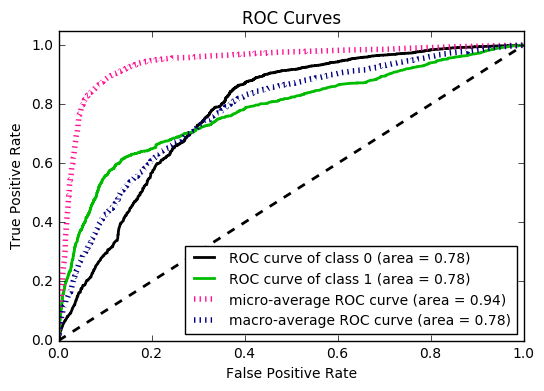

In [21]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_RF_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = rf_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

- <h4> Feature scaling

In [6]:
# Feature Scaling
sc = StandardScaler()
x_train_res = sc.fit_transform(x_train_res)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# Logistic Regression Classifier
- <h4> Model training

In [23]:
#Logistic Regression Algorithm

logdown = LogisticRegression()
logdown.fit(x_train_res, y_train_res)
predictions_LR = logdown.predict(x_val)

#print("Coefficients: ",  logdown.coef_)

print_results(x_val, y_val, predictions_LR, logdown)


Area under precission-recall is: 0.45684058683957207
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.83      0.89      5841
          1       0.33      0.65      0.44       749

avg / total       0.88      0.81      0.84      6590


 Confusion matrix:
  [[4864  977]
 [ 263  486]]


True negatives: 4864
False positives: 977
False negatives: 263
True positives:  486


- <h4> Model testing

In [24]:
predictions_LR_test = logdown.predict(x_test)
print_results(x_test, y_test, predictions_LR_test, logdown)


Area under precission-recall is: 0.4323407022680241
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.85      0.89      7319
          1       0.34      0.63      0.44       919

avg / total       0.88      0.82      0.84      8238


 Confusion matrix:
  [[6191 1128]
 [ 342  577]]


True negatives: 6191
False positives: 1128
False negatives: 342
True positives:  577


Area under Reciver Operating Characteristic Curve is:  0.7368684751970701


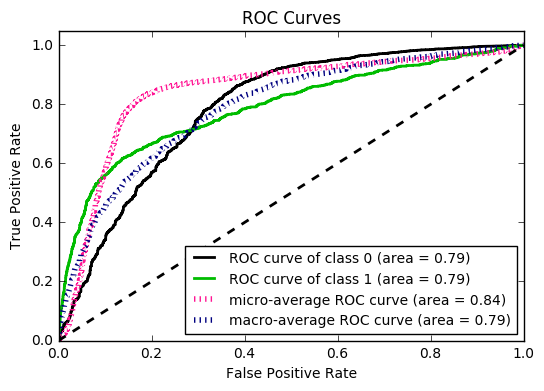

In [25]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_LR_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = logdown.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Support Vector Machines
- <h4> Model training

In [15]:
mask = np.random.choice([False, True], len(x_train_res), p=[0.65, 0.35])
x_train_res_temp = x_train_res[mask]
y_train_res_temp = y_train_res[mask]

In [16]:
#SVM algorithm
svm_classifier = SVC(kernel = 'rbf', random_state = 0, probability = True)
svm_classifier.fit(x_train_res_temp, y_train_res_temp)

predictions_SVC_val = svm_classifier.predict(x_val)

print_results(x_val, y_val, predictions_SVC_val, svm_classifier)


Area under precission-recall is: 0.3975484385890493
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      5841
          1       0.45      0.44      0.45       749

avg / total       0.87      0.87      0.87      6590


 Confusion matrix:
  [[5434  407]
 [ 418  331]]


True negatives: 5434
False positives: 407
False negatives: 418
True positives:  331


- <h4> Model testing

In [17]:
predictions_SVC_test = svm_classifier.predict(x_test)
print_results(x_test, y_test, predictions_SVC_test, svm_classifier)


Area under precission-recall is: 0.40116203243310417
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.94      0.93      7319
          1       0.46      0.44      0.45       919

avg / total       0.88      0.88      0.88      8238


 Confusion matrix:
  [[6850  469]
 [ 518  401]]


True negatives: 6850
False positives: 469
False negatives: 518
True positives:  401


Area under Reciver Operating Characteristic Curve is:  0.6861320298458512


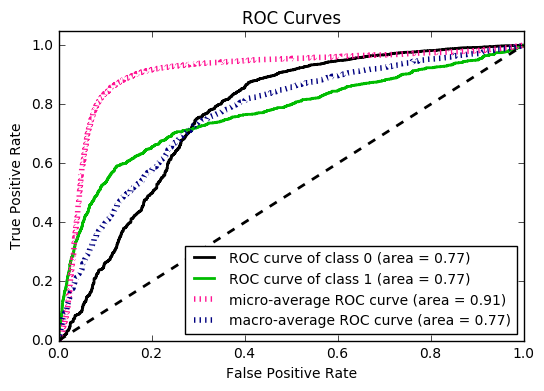

In [18]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_SVC_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = svm_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# K - nearest neighbours
- <h4> 
Model training (parameters adjusting)

In [19]:
#KNN Algorithm
#adjusting parameters for KNN
error_rate = []

# Will take some time
for i in range(1,20):  
    knn_classifier = KNeighborsClassifier(n_neighbors=i, metric = 'minkowski', p = 2)
    knn_classifier.fit(x_train_res, y_train_res)
    pred_i = knn_classifier.predict(x_val)
    error_rate.append(np.mean(pred_i != y_val))

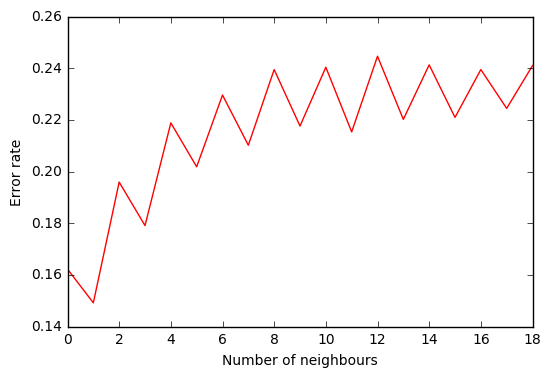

In [20]:
plt.xlabel("Number of neighbours")
plt.ylabel("Error rate")
plt.plot(error_rate, "r")

In [21]:
#From the plot above, we can see that the error_rate is smallest when number of neighbours is 1, so we take that N value
knn_classifier = KNeighborsClassifier(n_neighbors=1, metric = 'minkowski', p = 2)
knn_classifier.fit(x_train_res, y_train_res)
pred_i = knn_classifier.predict(x_val)

#Results
print_results(x_val, y_val, pred_i, knn_classifier)


Area under precission-recall is: 0.36706306075829753
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.90      0.91      5841
          1       0.31      0.35      0.33       749

avg / total       0.85      0.84      0.84      6590


 Confusion matrix:
  [[5259  582]
 [ 487  262]]


True negatives: 5259
False positives: 582
False negatives: 487
True positives:  262


- <h4> Model testing

In [22]:
predictions_KNN_test = knn_classifier.predict(x_test)
print_results(x_test, y_test, predictions_KNN_test, knn_classifier)


Area under precission-recall is: 0.37849754499500765
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.90      0.91      7319
          1       0.32      0.37      0.34       919

avg / total       0.85      0.84      0.85      8238


 Confusion matrix:
  [[6607  712]
 [ 583  336]]


True negatives: 6607
False positives: 712
False negatives: 583
True positives:  336


Area under Reciver Operating Characteristic Curve is:  0.6341668746852774


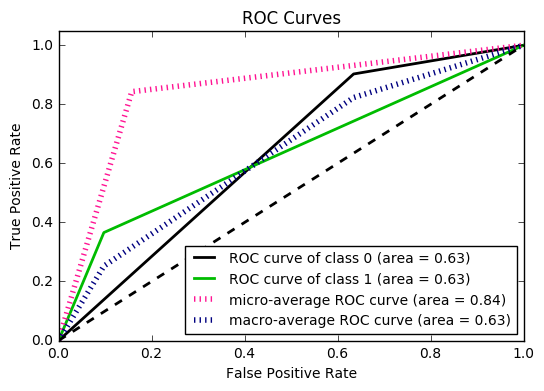

In [23]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_KNN_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = knn_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Gaussian Naive Bayes Classifier
- <h4> Model training

In [24]:
# Gaussian Naive Bayes
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(x_train_res, y_train_res)
#print(gaussian_classifier)
# make predictions
predicted = gaussian_classifier.predict(x_val)
# summarize the fit of the model

print_results(x_val, y_val, predicted, gaussian_classifier)


Area under precission-recall is: 0.4296292246208827
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.90      0.91      5841
          1       0.37      0.48      0.42       749

avg / total       0.87      0.85      0.86      6590


 Confusion matrix:
  [[5247  594]
 [ 393  356]]


True negatives: 5247
False positives: 594
False negatives: 393
True positives:  356


- <h4> Model testing

In [25]:
nb_predictions_test = gaussian_classifier.predict(x_test)
print_results(x_test, y_test, nb_predictions_test, gaussian_classifier)


Area under precission-recall is: 0.4191517463942025
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.90      0.92      7319
          1       0.37      0.45      0.40       919

avg / total       0.87      0.85      0.86      8238


 Confusion matrix:
  [[6610  709]
 [ 506  413]]


True negatives: 6610
False positives: 709
False negatives: 506
True positives:  413


Area under Reciver Operating Characteristic Curve is:  0.6762651830665368


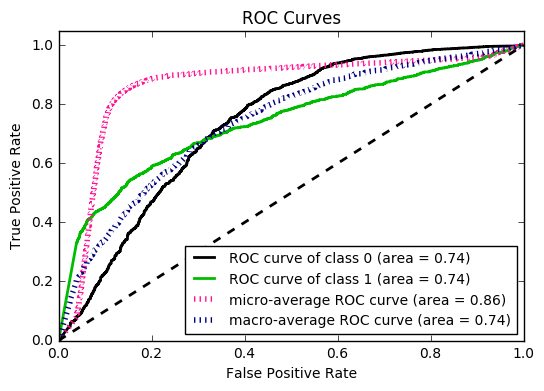

In [26]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, nb_predictions_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = gaussian_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()